## EECS 731 Project 6

### Step 0: Import relevant packages

In [1]:
# Import libraries necessary for this project
import os
import time
import datetime as dt

import sklearn
import numpy  as np
import pandas as pd
from pandas import compat
from scipy import stats

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import seaborn as sns; sns.set()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import mixture

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score
from sklearn import metrics

from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

compat.PY3 = True
print ("-----------------------------------------------------------------------")
print('The scikit-learn version is {}.'.format(sklearn.__version__))

-----------------------------------------------------------------------
The scikit-learn version is 0.20.3.


### Step 1: Pre requisite functions

#### This function load the data from the given path and finename

In [2]:
#Function to load the data
def loadData(path,filename):
    try:
             files = os.listdir(path)
             for f in files:
                 if f == filename:
                     data = pd.read_csv(os.path.join(path,f))
                     return data
            
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This function derives the shape of the dataset and returns the feature and target columns

In [3]:
#Function to explore the data
def exploreData(data):
    try:
           #Total number of records                                  
           rows = data.shape[0]
           cols = data.shape[1]    
          
           # Print the results
           print ("-----------------------------------------------------------------------")
           print ("Total number of records: {}".format(rows))
           print ("Total number of features: {}".format(cols))
           print ("-----------------------------------------------------------------------")
           
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This function computes the percentage of missing values per each column in the given dataset

In [4]:
def missingValues(data):
    try:
           # Total missing values
           mis_val = data.isnull().sum()
         
           # Percentage of missing values
           mis_val_percent = 100 * mis_val / len(data)
           
           # Make a table with the results
           mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
           
           # Rename the columns
           mis_val_table_ren_columns = mis_val_table.rename(
           columns = {0 : 'Missing Values', 1 : '% of Total Values'})
           mis_val_table_ren_columns.head(4 )
           # Sort the table by percentage of missing descending
           misVal = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                   '% of Total Values', ascending=False).round(1)
                     
           return misVal, mis_val_table_ren_columns

    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method scale the numerical features and label encoding for categorical features 

In [43]:
def transformData(df):
    try:    
        #Get the list of columns having negative columns from describe
        nc = []
        for i in df.columns:
            if df[i].min() < 0:
                nc.append(i)
         
        target = df['shares']
        features_transform = pd.DataFrame(data = df)
        features_transform = features_transform.drop(columns=['shares'], axis=1)
        
        #Add constant value to make the negative values as positive.
        for i in nc:
            minv = features_transform[i].min()
            minv = minv * -1
            features_transform[i] = features_transform[i] + minv

        #Get the list of columns that are skew
        sc = []
        for i in features_transform.columns:
            if df[i].max() > 1:
                sc.append(i)
                
        #Scale the data to reduce the skewness 
#        features_transform[sc] = features_transform[sc].apply(lambda x: np.log(x + 1))
        scaler = MinMaxScaler() # default=(0, 1)
        features_transform[sc] = scaler.fit_transform(features_transform[sc])
        
        ind = np.where(target < 1400)
        target.iloc[ind] = 1
        
        ind = np.where(target >=1400)
        target.iloc[ind] = 0

        return features_transform, target
        
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)


#### This method splits data in to training and test data

In [44]:
#split the data in to train and test data
def splitData(features,target,testsize):
    try:
        # Split the 'features' and 'income' data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target, 
                                                    test_size = testsize, 
                                                    random_state = 1)

        # Show the results of the split
        print ("Features training set has {} samples.".format(X_train.shape[0]))
        print ("Features testing set has {} samples.".format(X_test.shape[0]))
        print ("Target training set has {} samples.".format(y_train.shape[0]))
        print ("Target testing set has {} samples.".format(y_test.shape[0]))
        print ("-----------------------------------------------------------------------")
        return X_train, X_test, y_train, y_test
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implements Multinomial Bayesian classifier

In [45]:
def multinomialnb(X_train, X_test, y_train, y_test):
    try:
        #logic
        clf = MultinomialNB()
        params = {}

        scoring_fnc = make_scorer(fbeta_score,average='micro',beta=0.5)
        learner = GridSearchCV(clf,params,scoring=scoring_fnc)
        results = {}
         
        start_time = time.clock()
        grid = learner.fit(X_train,y_train)
        
        end_time = time.clock()
        results['train_time'] = end_time - start_time
        clf_fit_train = grid.best_estimator_
        start_time = time.clock()
        clf_predict_train = clf_fit_train.predict(X_train)
        clf_predict_test = clf_fit_train.predict(X_test)
        end_time = time.clock()
        results['pred_time'] = end_time - start_time  
         
        results['acc_train'] = accuracy_score(y_train, clf_predict_train)
        results['acc_test']  = accuracy_score(y_test, clf_predict_test)
        results['f_train']   = fbeta_score(y_train, clf_predict_train, average='micro', beta=1)
        results['f_test']    = fbeta_score(y_test, clf_predict_test, average='micro', beta=1.5)
        
        return results,clf_fit_train      
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implements SVM Classifier

In [46]:
def svmClassifier(X_train, X_test, y_train, y_test):
    try:
        #Decision tree classifier
        #learner = DecisionTreeClassifier(criterion=method, max_depth=depth, random_state=1)
        clf = svm.SVC(random_state=0)
        params = {'gamma':[0.001]}
        #params = {'criterion':['gini','entropy'], 'max_depth' : np.array([6,7,8])}
         
        scoring_fnc = make_scorer(fbeta_score,average='micro',beta=0.5)
        learner = GridSearchCV(clf,params,scoring=scoring_fnc)
        results = {}
         
        start_time = time.clock()
        grid = learner.fit(X_train,y_train)
         
        end_time = time.clock()
        results['train_time'] = end_time - start_time
        clf_fit_train = grid.best_estimator_
        start_time = time.clock()
        clf_predict_train = clf_fit_train.predict(X_train)
        clf_predict_test = clf_fit_train.predict(X_test)
        end_time = time.clock()
        results['pred_time'] = end_time - start_time  
         
        results['acc_train'] = accuracy_score(y_train, clf_predict_train)
        results['acc_test']  = accuracy_score(y_test, clf_predict_test)
        
        return results,clf_fit_train      
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implements Ramdom Forest classifier

In [47]:
def randomForest(X_train, X_test, y_train, y_test):
    try:
        clf = RandomForestClassifier(max_depth=2, random_state=0)
        #params = {}
        params = {'criterion':['gini','entropy'], 'max_depth' : np.array([6,7,8]),'random_state': [0]}
         
        scoring_fnc = make_scorer(fbeta_score,average='micro',beta=0.5)
        learner = GridSearchCV(clf,params,scoring=scoring_fnc)
        results = {}
         
        start_time = time.clock()
        grid = learner.fit(X_train,y_train)
         
        end_time = time.clock()
        results['train_time'] = end_time - start_time
        clf_fit_train = grid.best_estimator_
        start_time = time.clock()
        clf_predict_train = clf_fit_train.predict(X_train)
        clf_predict_test = clf_fit_train.predict(X_test)
        end_time = time.clock()
        results['pred_time'] = end_time - start_time  
         
        results['acc_train'] = accuracy_score(y_train, clf_predict_train)
        results['acc_test']  = accuracy_score(y_test, clf_predict_test)
         
        return results,clf_fit_train, 
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implement Principal component analyis 

In [48]:
def pca(features,dim):
    try:
        #logic
        pcan = PCA(n_components=dim)
        pcan.fit(features)
        reduced_dim = pcan.transform(features)
        
#        from pics import pca_results
#        _ = pca_results(features, pca)
        
        dlist = [];
        for i in range(dim):
            s = "D" + str(i)
            dlist.append(s)
        pca_comp = pd.DataFrame(pcan.components_,columns=features.columns,index = dlist)
#        pca_comp.transpose().to_csv('test.csv')
        return reduced_dim, pca_comp, pcan
    
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This function implement the biplot

In [49]:
def biplot(good_data, reduced_data, pca):

    fig, ax = plt.subplots(figsize = (14,14))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 7.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=0.2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=30)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

#### This method implement Gaussian mixture clustering

In [50]:
def gclus(reduced_data,ic):
    try:
        cluster =  mixture.GaussianMixture(covariance_type='spherical', init_params='kmeans',
        max_iter=100, means_init=None, n_components=ic, n_init=1,
        precisions_init=None, random_state=None, reg_covar=1e-06,
        tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
        weights_init=None).fit(reduced_data)
        
        pred = cluster.predict(reduced_data)
        
        centers = np.empty(shape=(cluster.n_components, reduced_data.shape[1]))
        for i in range(cluster.n_components):
            density = stats.multivariate_normal(cov=cluster.covariances_[i], mean=cluster.means_[i]).logpdf(reduced_data)
            centers[i, :] = reduced_data[np.argmax(density)]
        score = metrics.silhouette_score(reduced_data, pred, metric='euclidean')
        
        return cluster, centers,score
        
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### This method implements the decision boundary

In [51]:
def decBound(reduced_df,preds,centers):
    try:
        #logic
        predictions = pd.DataFrame(preds, columns = ['Cluster'])
        plot_data = pd.concat([predictions, reduced_df], axis = 1)

        # Generate the cluster plot
        fig, ax = plt.subplots(figsize = (14,8))

        # Color map
        cmap = cm.get_cmap('gist_rainbow')

        # Color the points based on assigned cluster
        for i, cluster in plot_data.groupby('Cluster'):   
            cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                         color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);
    
        # Plot centers with indicators
        for i, c in enumerate(centers):
            ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                       alpha = 1, linewidth = 2, marker = 'o', s=200);
            ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);
    
        # Set plot title
        ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### Get the counts of binary features

In [52]:
def getCounts(flist,dat):
    try:
        #logic
        cols = []; counts = []; fake = [];
        for f in flist:
            ind = []
            ind = np.where((dat[f] == 1) & (dat['shares'] == 1))[0].tolist()
            #df1 = dat.loc[ind,['data_channel_is_lifestyle','shares']]
            cols.append(f)
            counts.append(len(ind))
            fake.append(False)
        
        for f in flist:
            ind = []
            ind = np.where((dat[f] == 1) & (dat['shares'] == 0))[0].tolist()
            #df1 = dat.loc[ind,['data_channel_is_lifestyle','shares']]
            cols.append(f)
            counts.append(len(ind))
            fake.append(True)
            
        df = pd.DataFrame(columns = ['feature','count','fake'])
        df['feature'] = cols
        df['count']= counts
        df['fake'] = fake 
        
        return df
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### Get the counts the continous features

In [53]:
def get2Counts(flist,dat):
    try:
        #logic
        cols = []; counts = []; fake = [];
        for f in flist:
            ind = []
            ind = np.where((dat[f] != ' ') & (dat['shares'] == 1))[0].tolist()
            #df1 = dat.loc[ind,['data_channel_is_lifestyle','shares']]
            cols.append(f)
            counts.append(len(ind))
            fake.append(False)
        
        for f in flist:
            ind = []
            ind = np.where((dat[f] != ' ') & (dat['shares'] == 0))[0].tolist()
            #df1 = dat.loc[ind,['data_channel_is_lifestyle','shares']]
            cols.append(f)
            counts.append(len(ind))
            fake.append(True)
            
        df = pd.DataFrame(columns = ['feature','count','fake'])
        df['feature'] = cols
        df['count']= counts
        df['fake'] = fake 
        
        return df
    except Exception as ex:
           print ("-----------------------------------------------------------------------")
           template = "An exception of type {0} occurred. Arguments:\n{1!r}"
           message = template.format(type(ex).__name__, ex.args)
           print (message)

#### Load and check the data

In [73]:
path = r'C:\Users\pmspr\Documents\HS\MS\Sem 3\EECS 731\Project\Repos\News Popularity\Git\EECS-731-Project-7\Data'
filename = "OnlineNewsPopularity.csv"
data = loadData(path,filename)
data.columns = data.columns.str.strip()
data_b = data
#Check the missing values
misVal, mis_val_table_ren_columns = missingValues(data)
display(mis_val_table_ren_columns.head(20))

,Missing Values,% of Total Values
url,0,0.0
timedelta,0,0.0
n_tokens_title,0,0.0
n_tokens_content,0,0.0
n_unique_tokens,0,0.0
n_non_stop_words,0,0.0
n_non_stop_unique_tokens,0,0.0
num_hrefs,0,0.0
num_self_hrefs,0,0.0
num_imgs,0,0.0


### Understand the features

In [74]:
des = data.describe().transpose()
display(des)

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,354.530471,214.163767,8.00000,164.000000,339.000000,542.000000,731.000000
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
n_unique_tokens,39644.0,0.548216,3.520708,0.00000,0.470870,0.539226,0.608696,701.000000
n_non_stop_words,39644.0,0.996469,5.231231,0.00000,1.000000,1.000000,1.000000,1042.000000
n_non_stop_unique_tokens,39644.0,0.689175,3.264816,0.00000,0.625739,0.690476,0.754630,650.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000


### Feature Engineering

-----------------------------------------------------------------------
Total number of records: 39644
Total number of features: 60
-----------------------------------------------------------------------


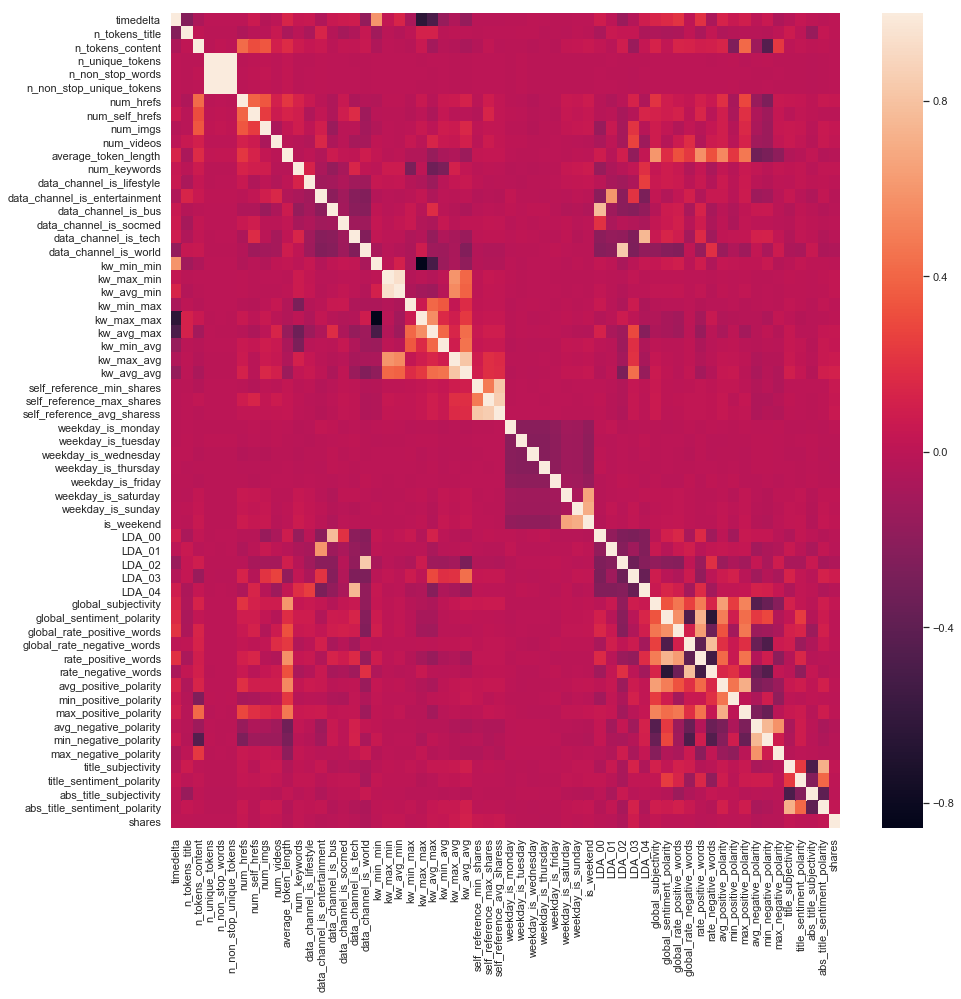

In [75]:
#Remove rows with missing target values
col = ['url']
data = data.drop(columns=col, axis=1)

exploreData(data)

#KDE Density plots are taking huge time to run.
#from pandas.plotting import scatter_matrix
#Density plot
#scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
#sns.pairplot(data)

#Correlation plot
f, axes = plt.subplots(1, 1, figsize=(15, 15))
cor = data .corr()

#heat map
ax = sns.heatmap(cor,ax=axes)
plt.show()

#### Plot the important feature counts

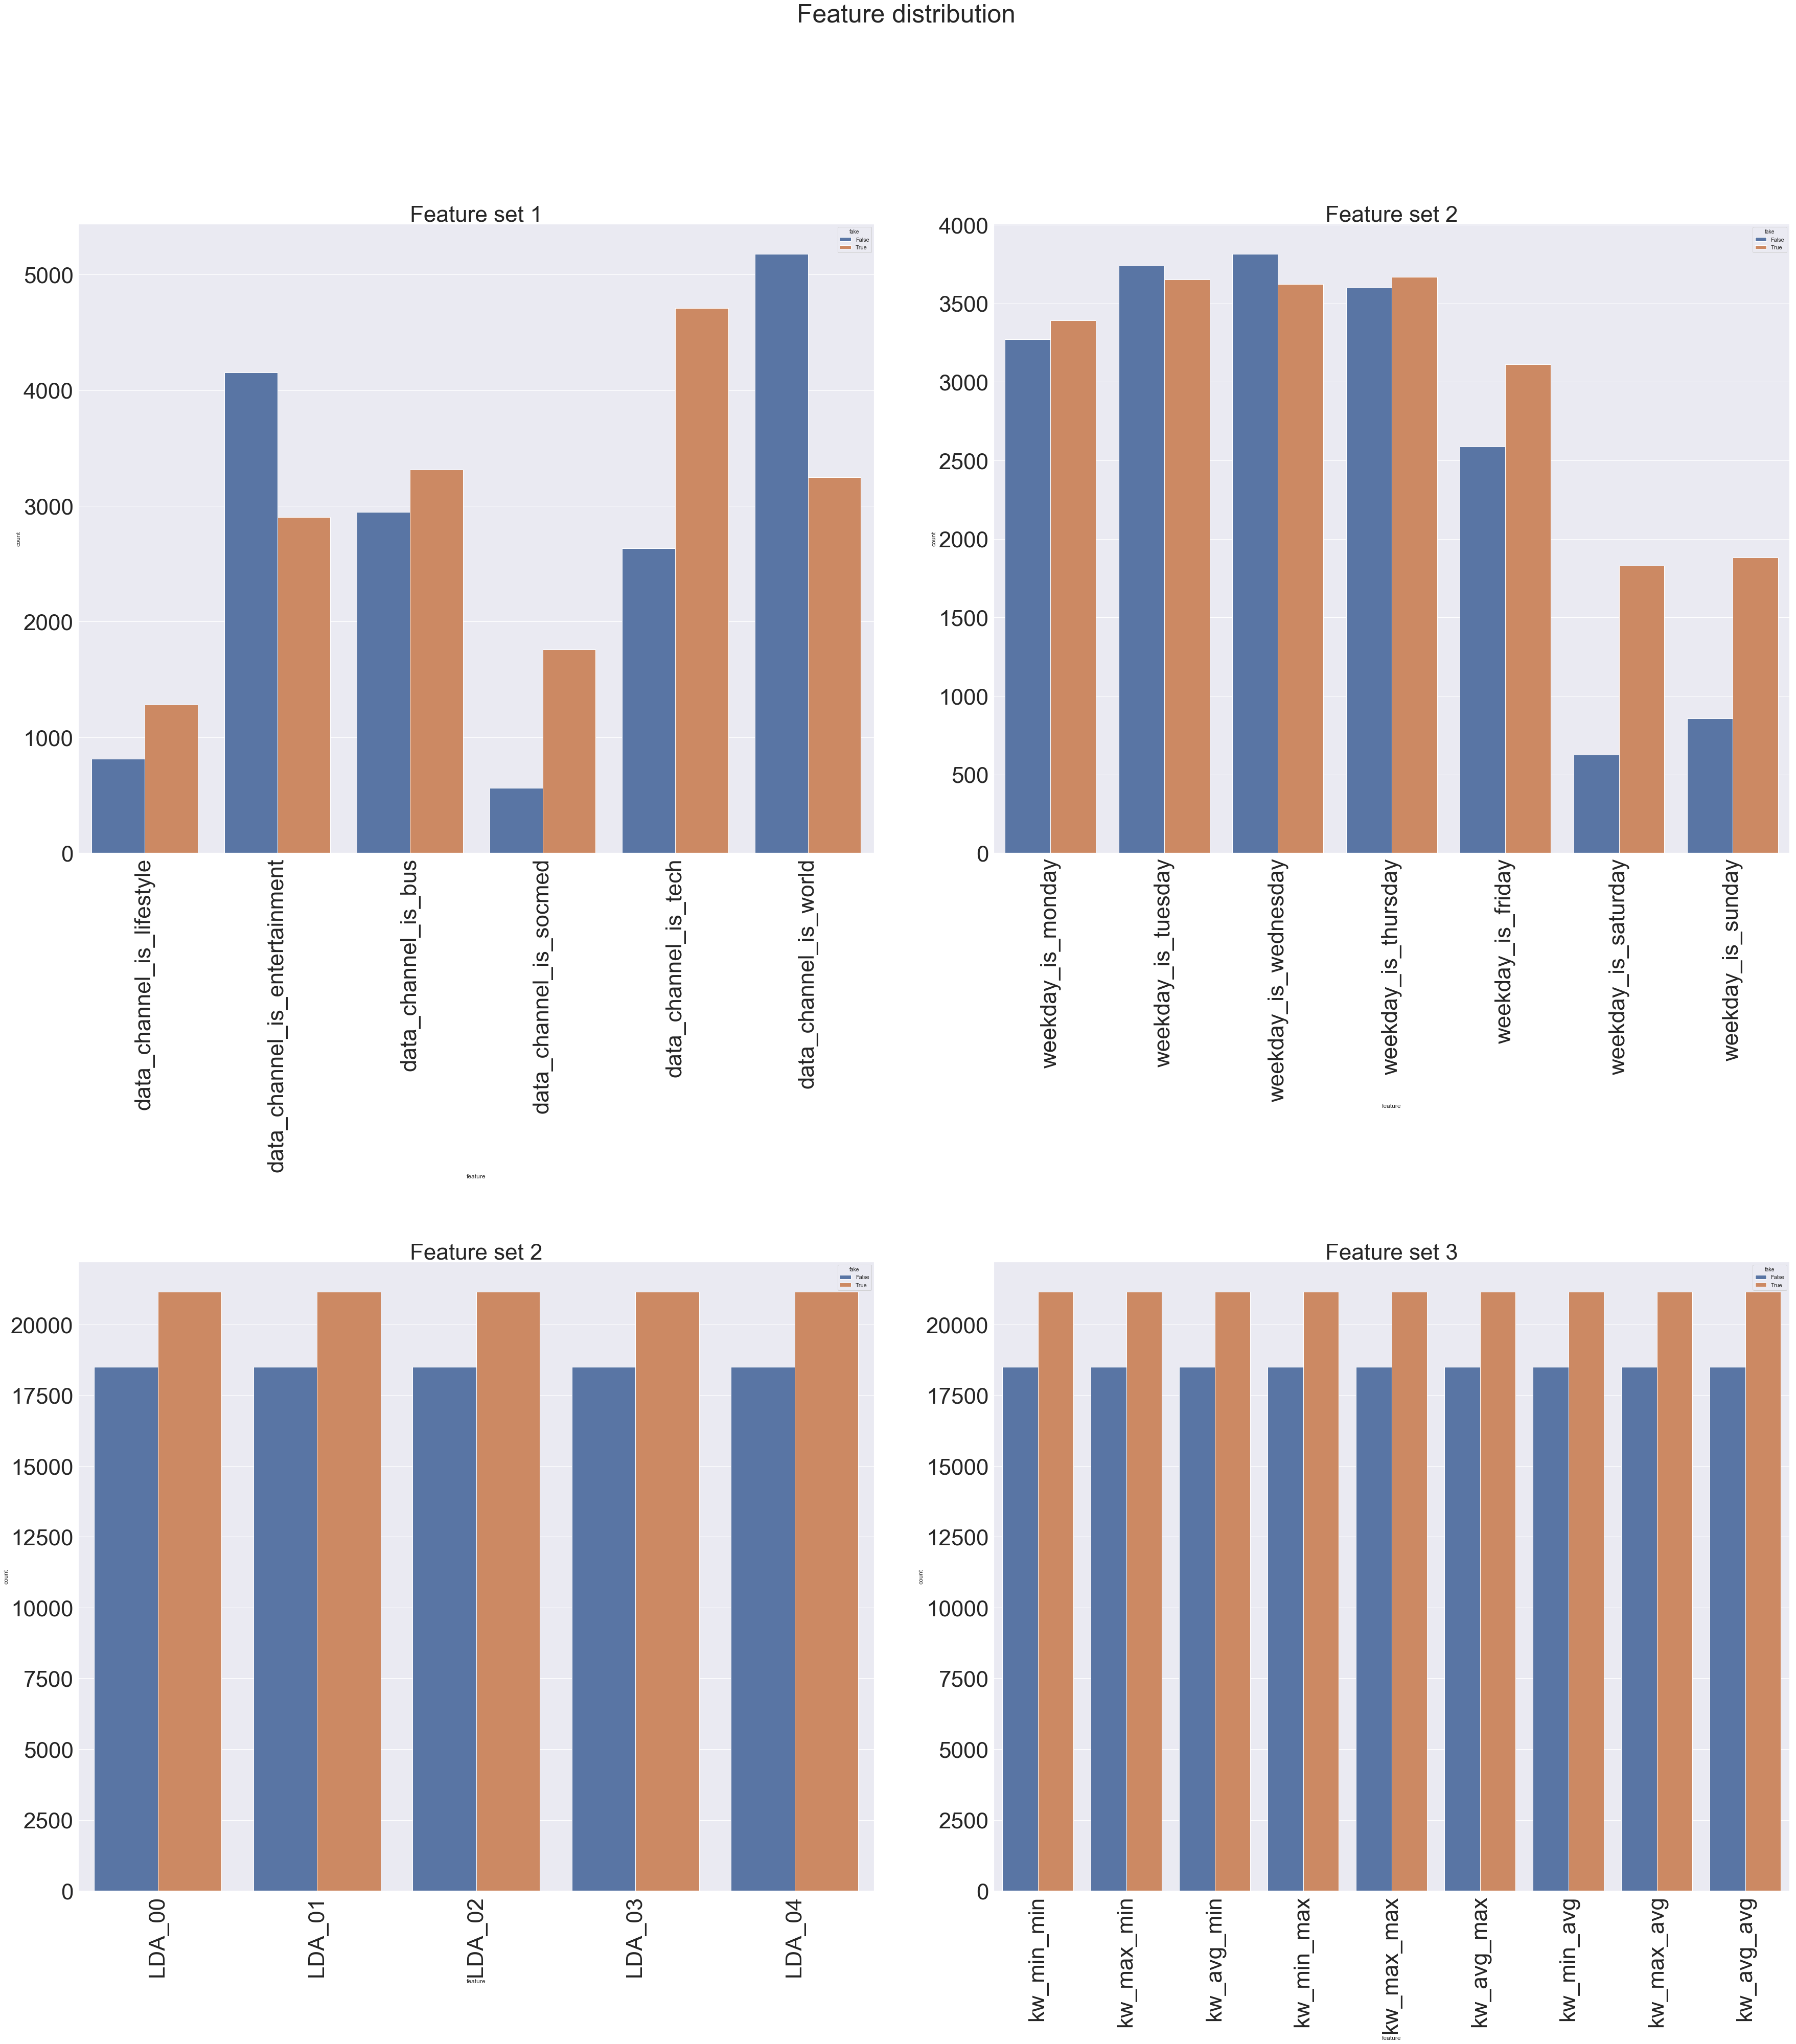

In [76]:
dat = data_b
dat.columns = dat.columns.str.strip()
ind = np.where(dat['shares'] < 1400)
dat['shares'].iloc[ind] = 1
ind = np.where(dat['shares'] >=1400)
dat['shares'].iloc[ind] = 0

flist = []
f1list = ['data_channel_is_lifestyle','data_channel_is_entertainment','data_channel_is_bus',
         'data_channel_is_socmed','data_channel_is_tech','data_channel_is_world']
flist.append(f1list)
f2list = ['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday',
         'weekday_is_thursday','weekday_is_friday','weekday_is_saturday','weekday_is_sunday']
flist.append(f2list)
f3list = ['LDA_00','LDA_01','LDA_02','LDA_03','LDA_04']
flist.append(f3list)
f4list = ['kw_min_min','kw_max_min','kw_avg_min',
          'kw_min_max','kw_max_max','kw_avg_max',
          'kw_min_avg','kw_max_avg','kw_avg_avg']
flist.append(f4list)

#from projectFunctions import getCounts, get2Counts

fig, ax = plt.subplots(2,2,figsize = (60,60))
fig.subplots_adjust(hspace=0.65, wspace=0.15)
for fl in range(len(flist)):
    if fl < 2:
        df = getCounts(flist[fl],dat)
        sns.barplot(x='feature', y = 'count', hue='fake', data=df, ax = ax[0][fl])
        st = "Feature set " + str(fl+1)
        ax[0][fl].set_title(st,fontsize=44)
        _ = ax[0][fl].tick_params(axis="y", labelsize=44)
        _ = ax[0][fl].tick_params(axis="x", labelsize=44)
        plt.sca(ax[0][fl])
        plt.xticks(rotation=90)
    else:
        df = get2Counts(flist[fl],dat)
        _ = sns.barplot(x='feature', y = 'count', hue='fake', data=df, ax = ax[1][fl-2])
        st = "Feature set " + str(fl)
        _ = ax[1][fl-2].tick_params(axis="y", labelsize=44)
        _ = ax[1][fl-2].tick_params(axis="x", labelsize=44)
        ax[1][fl-2].set_title(st,fontsize=44)
        plt.sca(ax[1][fl-2])
        plt.xticks(rotation=90)
plt.suptitle("Feature distribution",fontsize=50)
plt.show()

#### Explore and Tansform the data

In [77]:
data_raw = data
features, target = transformData(data_raw)
display(features.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
timedelta,39644.0,0.479295,0.296215,0.0,0.215768,0.457815,0.738589,1.000000
n_tokens_title,39644.0,0.399940,0.100668,0.0,0.333333,0.380952,0.476190,1.000000
n_tokens_content,39644.0,0.064493,0.055594,0.0,0.029030,0.048265,0.084494,1.000000
n_unique_tokens,39644.0,0.000782,0.005022,0.0,0.000672,0.000769,0.000868,1.000000
n_non_stop_words,39644.0,0.000956,0.005020,0.0,0.000960,0.000960,0.000960,1.000000
n_non_stop_unique_tokens,39644.0,0.001060,0.005023,0.0,0.000963,0.001062,0.001161,1.000000
num_hrefs,39644.0,0.035802,0.037276,0.0,0.013158,0.026316,0.046053,1.000000
num_self_hrefs,39644.0,0.028393,0.033234,0.0,0.008621,0.025862,0.034483,1.000000
num_imgs,39644.0,0.035501,0.064917,0.0,0.007812,0.007812,0.031250,1.000000
num_videos,39644.0,0.013735,0.045141,0.0,0.000000,0.000000,0.010989,1.000000


#### Split the data between training and test sizes

In [78]:
#Split the data 70% training and 30% test
X_train, X_test, y_train, y_test = splitData(features,target,0.3)

Features training set has 27750 samples.
Features testing set has 11894 samples.
Target training set has 27750 samples.
Target testing set has 11894 samples.
-----------------------------------------------------------------------


#### Implement the Multinomial bayesian classifier

In [79]:
#Multinomial naive bayesian classifer
results,learner = multinomialnb(X_train, X_test, y_train, y_test)

print ("Times for Training, Prediction: %.5f, %.5f" %(results['train_time'], results['pred_time']))    
print ("Accuracy for Training, Test sets: %.5f, %.5f" %(results['acc_train'], results['acc_test']))     
print ("-----------------------------------------------------------------------")

Times for Training, Prediction: 0.07505, 0.00467
Accuracy for Training, Test sets: 0.62930, 0.63032
-----------------------------------------------------------------------


#### Implement SVM Classifier

In [85]:
#Implement Support Vector Machine Classifier
results,learner = svmClassifier(X_train, X_test, y_train, y_test)

print ("Times for Training, Prediction: %.5f, %.5f" %(results['train_time'], results['pred_time']))    
print ("Accuracy for Training, Test sets: %.5f, %.5f" %(results['acc_train'], results['acc_test']))     
print ("-----------------------------------------------------------------------")

Times for Training, Prediction: 232.36762, 63.84094
Accuracy for Training, Test sets: 0.61542, 0.61308
-----------------------------------------------------------------------


#### Implement Random forest tree 

In [80]:
results,learner = randomForest(X_train, X_test, y_train, y_test)
featureImp = pd.DataFrame(columns=['feature','importance'])
featureImp['feature'] = features.columns
featureImp['importance'] = learner.feature_importances_
featureImp = featureImp.sort_values(by='importance')
display(featureImp)
print ("-----------------------------------------------------------------------")
print ("Times for Training, Prediction: %.5f, %.5f" %(results['train_time'], results['pred_time']))    
print ("Accuracy for Training, Test sets: %.5f, %.5f" %(results['acc_train'], results['acc_test']))     
print ("-----------------------------------------------------------------------")

,feature,importance
4,n_non_stop_words,0.000000
30,weekday_is_monday,0.000394
31,weekday_is_tuesday,0.000398
32,weekday_is_wednesday,0.000411
34,weekday_is_friday,0.000511
33,weekday_is_thursday,0.000614
12,data_channel_is_lifestyle,0.000911
18,kw_min_min,0.002676
53,min_negative_polarity,0.002785
51,max_positive_polarity,0.003009


-----------------------------------------------------------------------
Times for Training, Prediction: 6.04254, 0.03265
Accuracy for Training, Test sets: 0.70404, 0.66050
-----------------------------------------------------------------------


#### Implement Principal component analysis

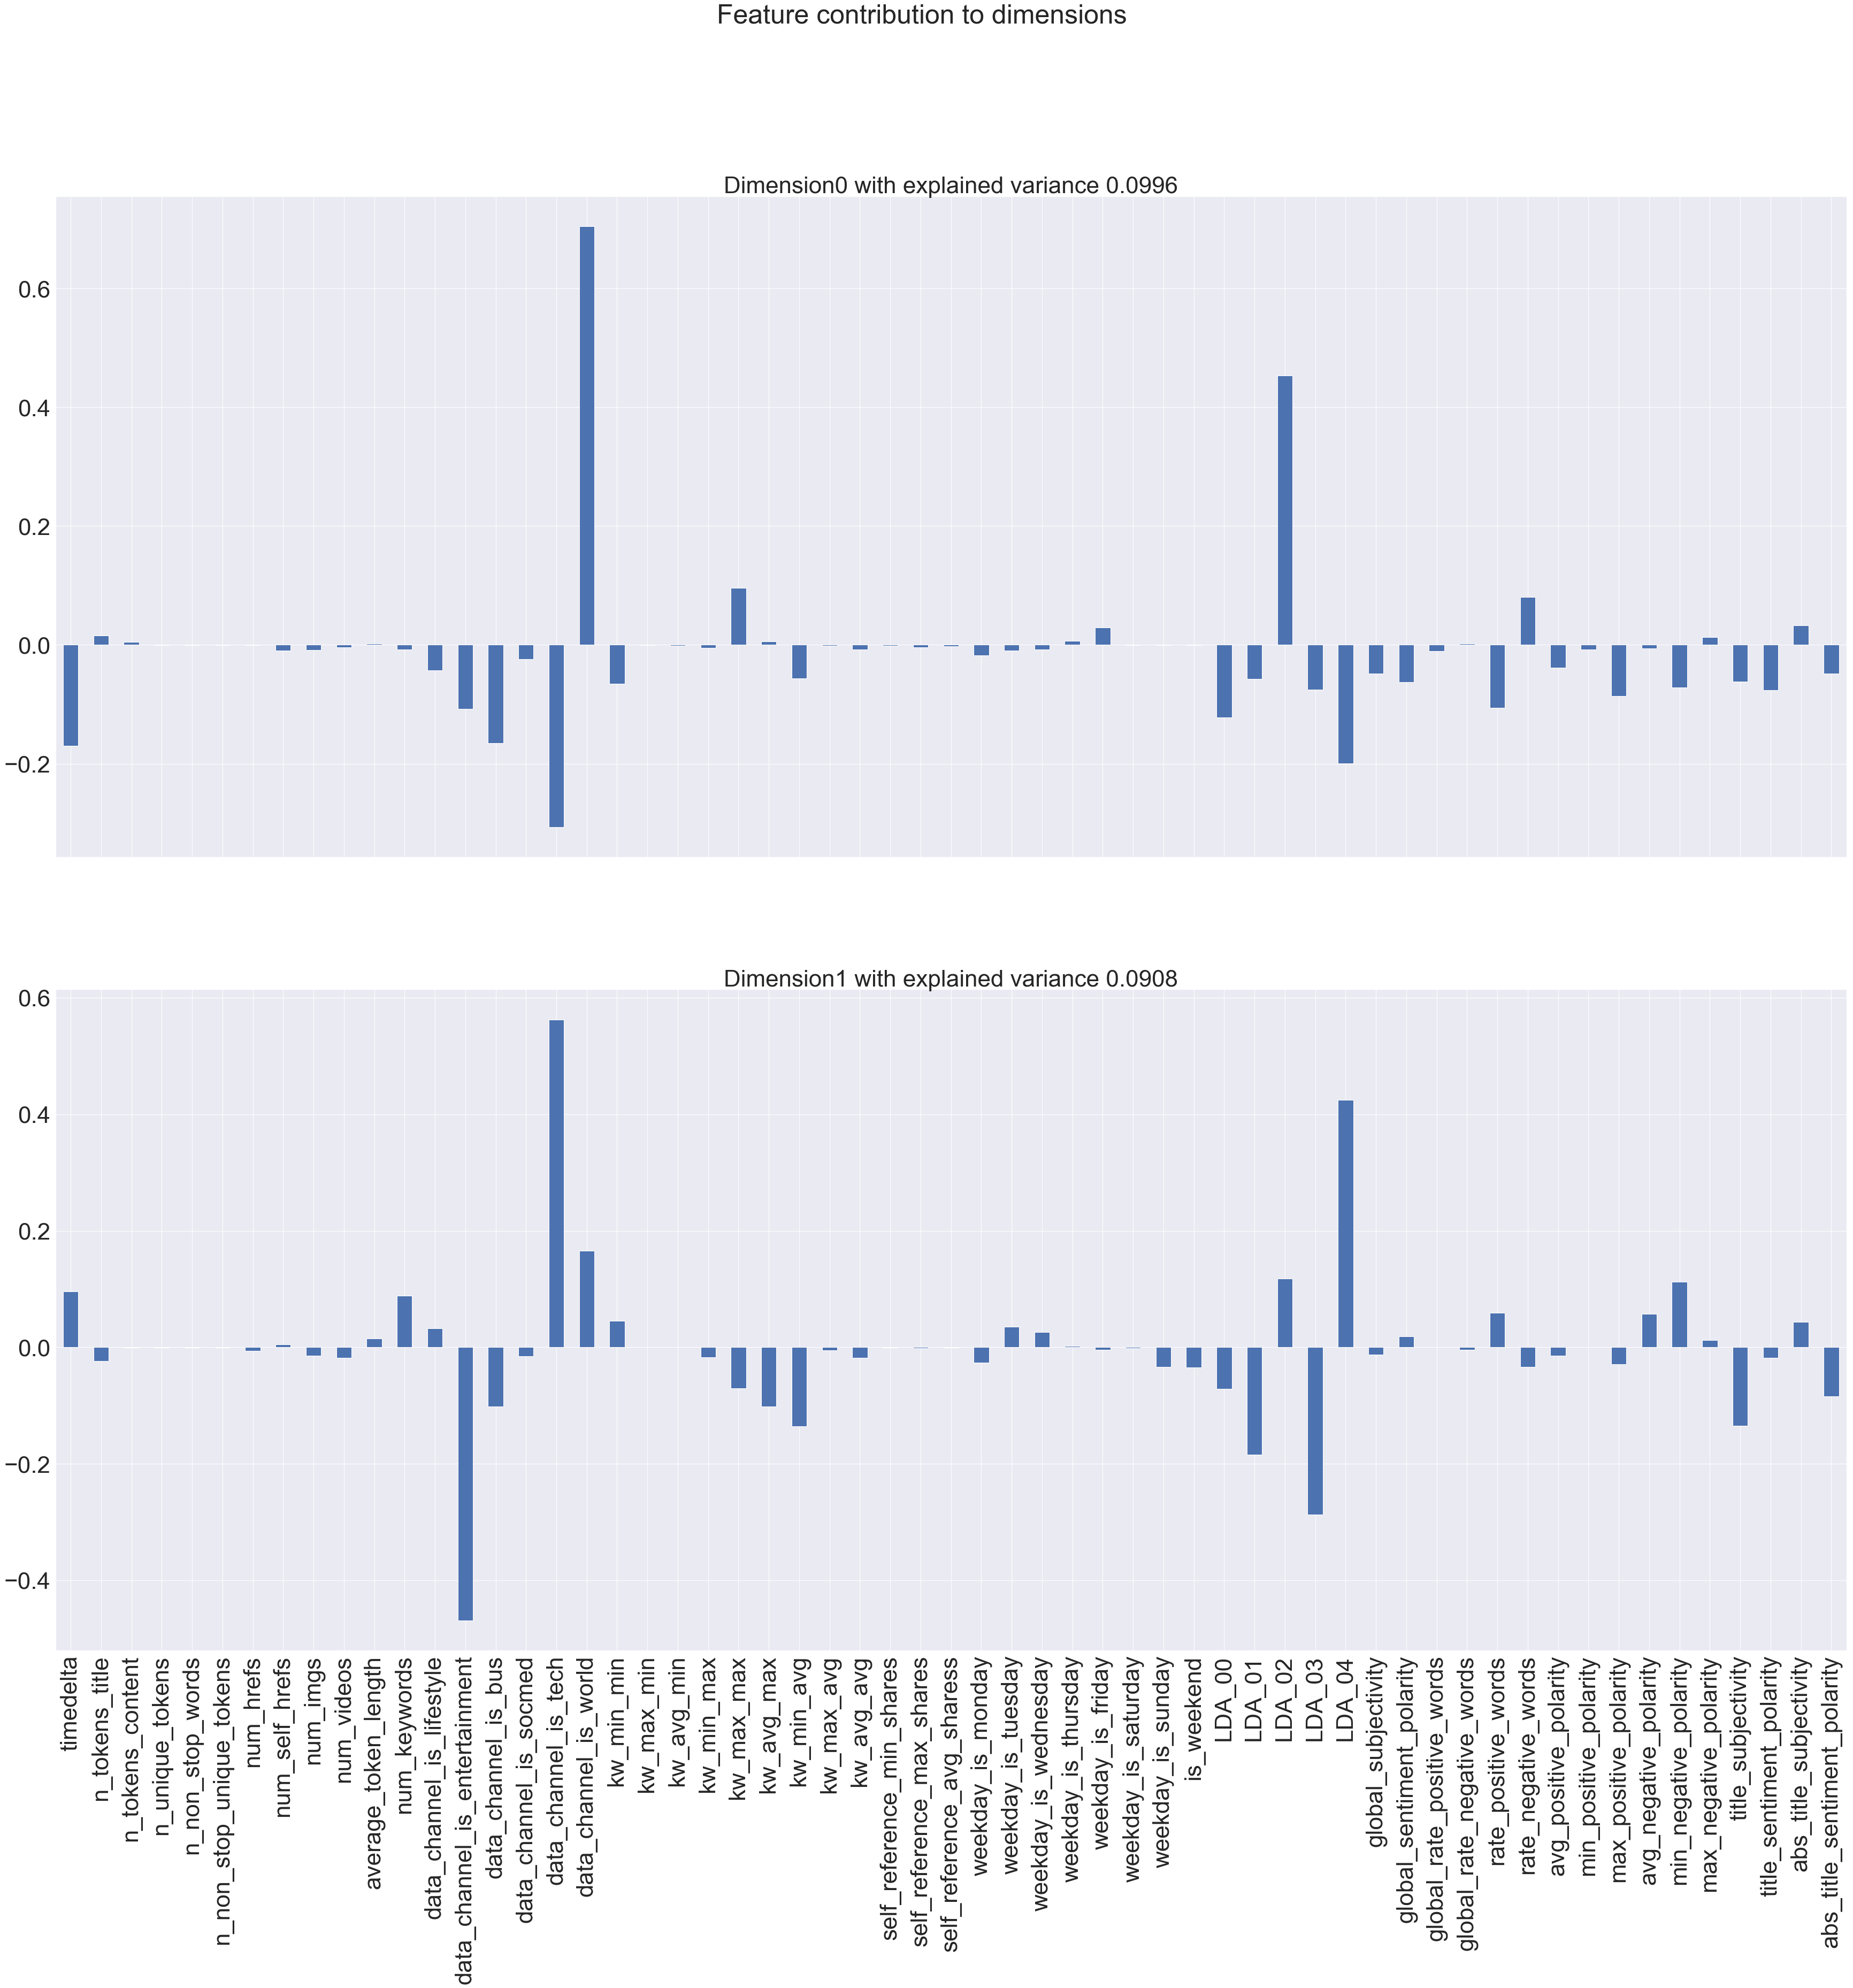

In [81]:
#Implement the PCA with 6 dimensions
dim = 2
reduced_f, pca_comp, learner = pca(features,dim)
reduced_df = pd.DataFrame(reduced_f, columns = ['Dimension 1', 'Dimension 2'])

pca_comp = pca_comp.transpose()

fig, ax = plt.subplots(dim,1,figsize = (60,50))
for j in range(dim):
    df = pca_comp.iloc[:,j]
    _ = df.plot(ax = ax[j], kind = 'bar');
    st = "Dimension" + str(j) + " with explained variance " + str(np.round(learner.explained_variance_ratio_[j],4))
    ax[j].set_title(st,fontsize=44)
    if j < (dim-1):
        _ = ax[j].set_xticklabels([])
        _ = ax[j].tick_params(axis="y", labelsize=44)
    else:
        _ = ax[dim-1].set_xticklabels(df.index.tolist(), fontsize=44, rotation=90)
        _ = ax[dim-1].tick_params(axis="y", labelsize=44)
    
plt.suptitle("Feature contribution to dimensions",fontsize=50)
plt.show()
#_ = ax.set_ylabel("Feature Weights")
#_ = ax.set_xticklabels(df.index.tolist(), fontsize=10, rotation=90)

Analysis - 
1. We have tried PCA analysis with 6 dimensions, but observed that last four dimensions has less explained variance.
2. If we reduce dimensions from 6 to 2, we have most of the variance of the original features. 
3. Having two dimensions has better performance at clustering. 

#### Plot the data and variance

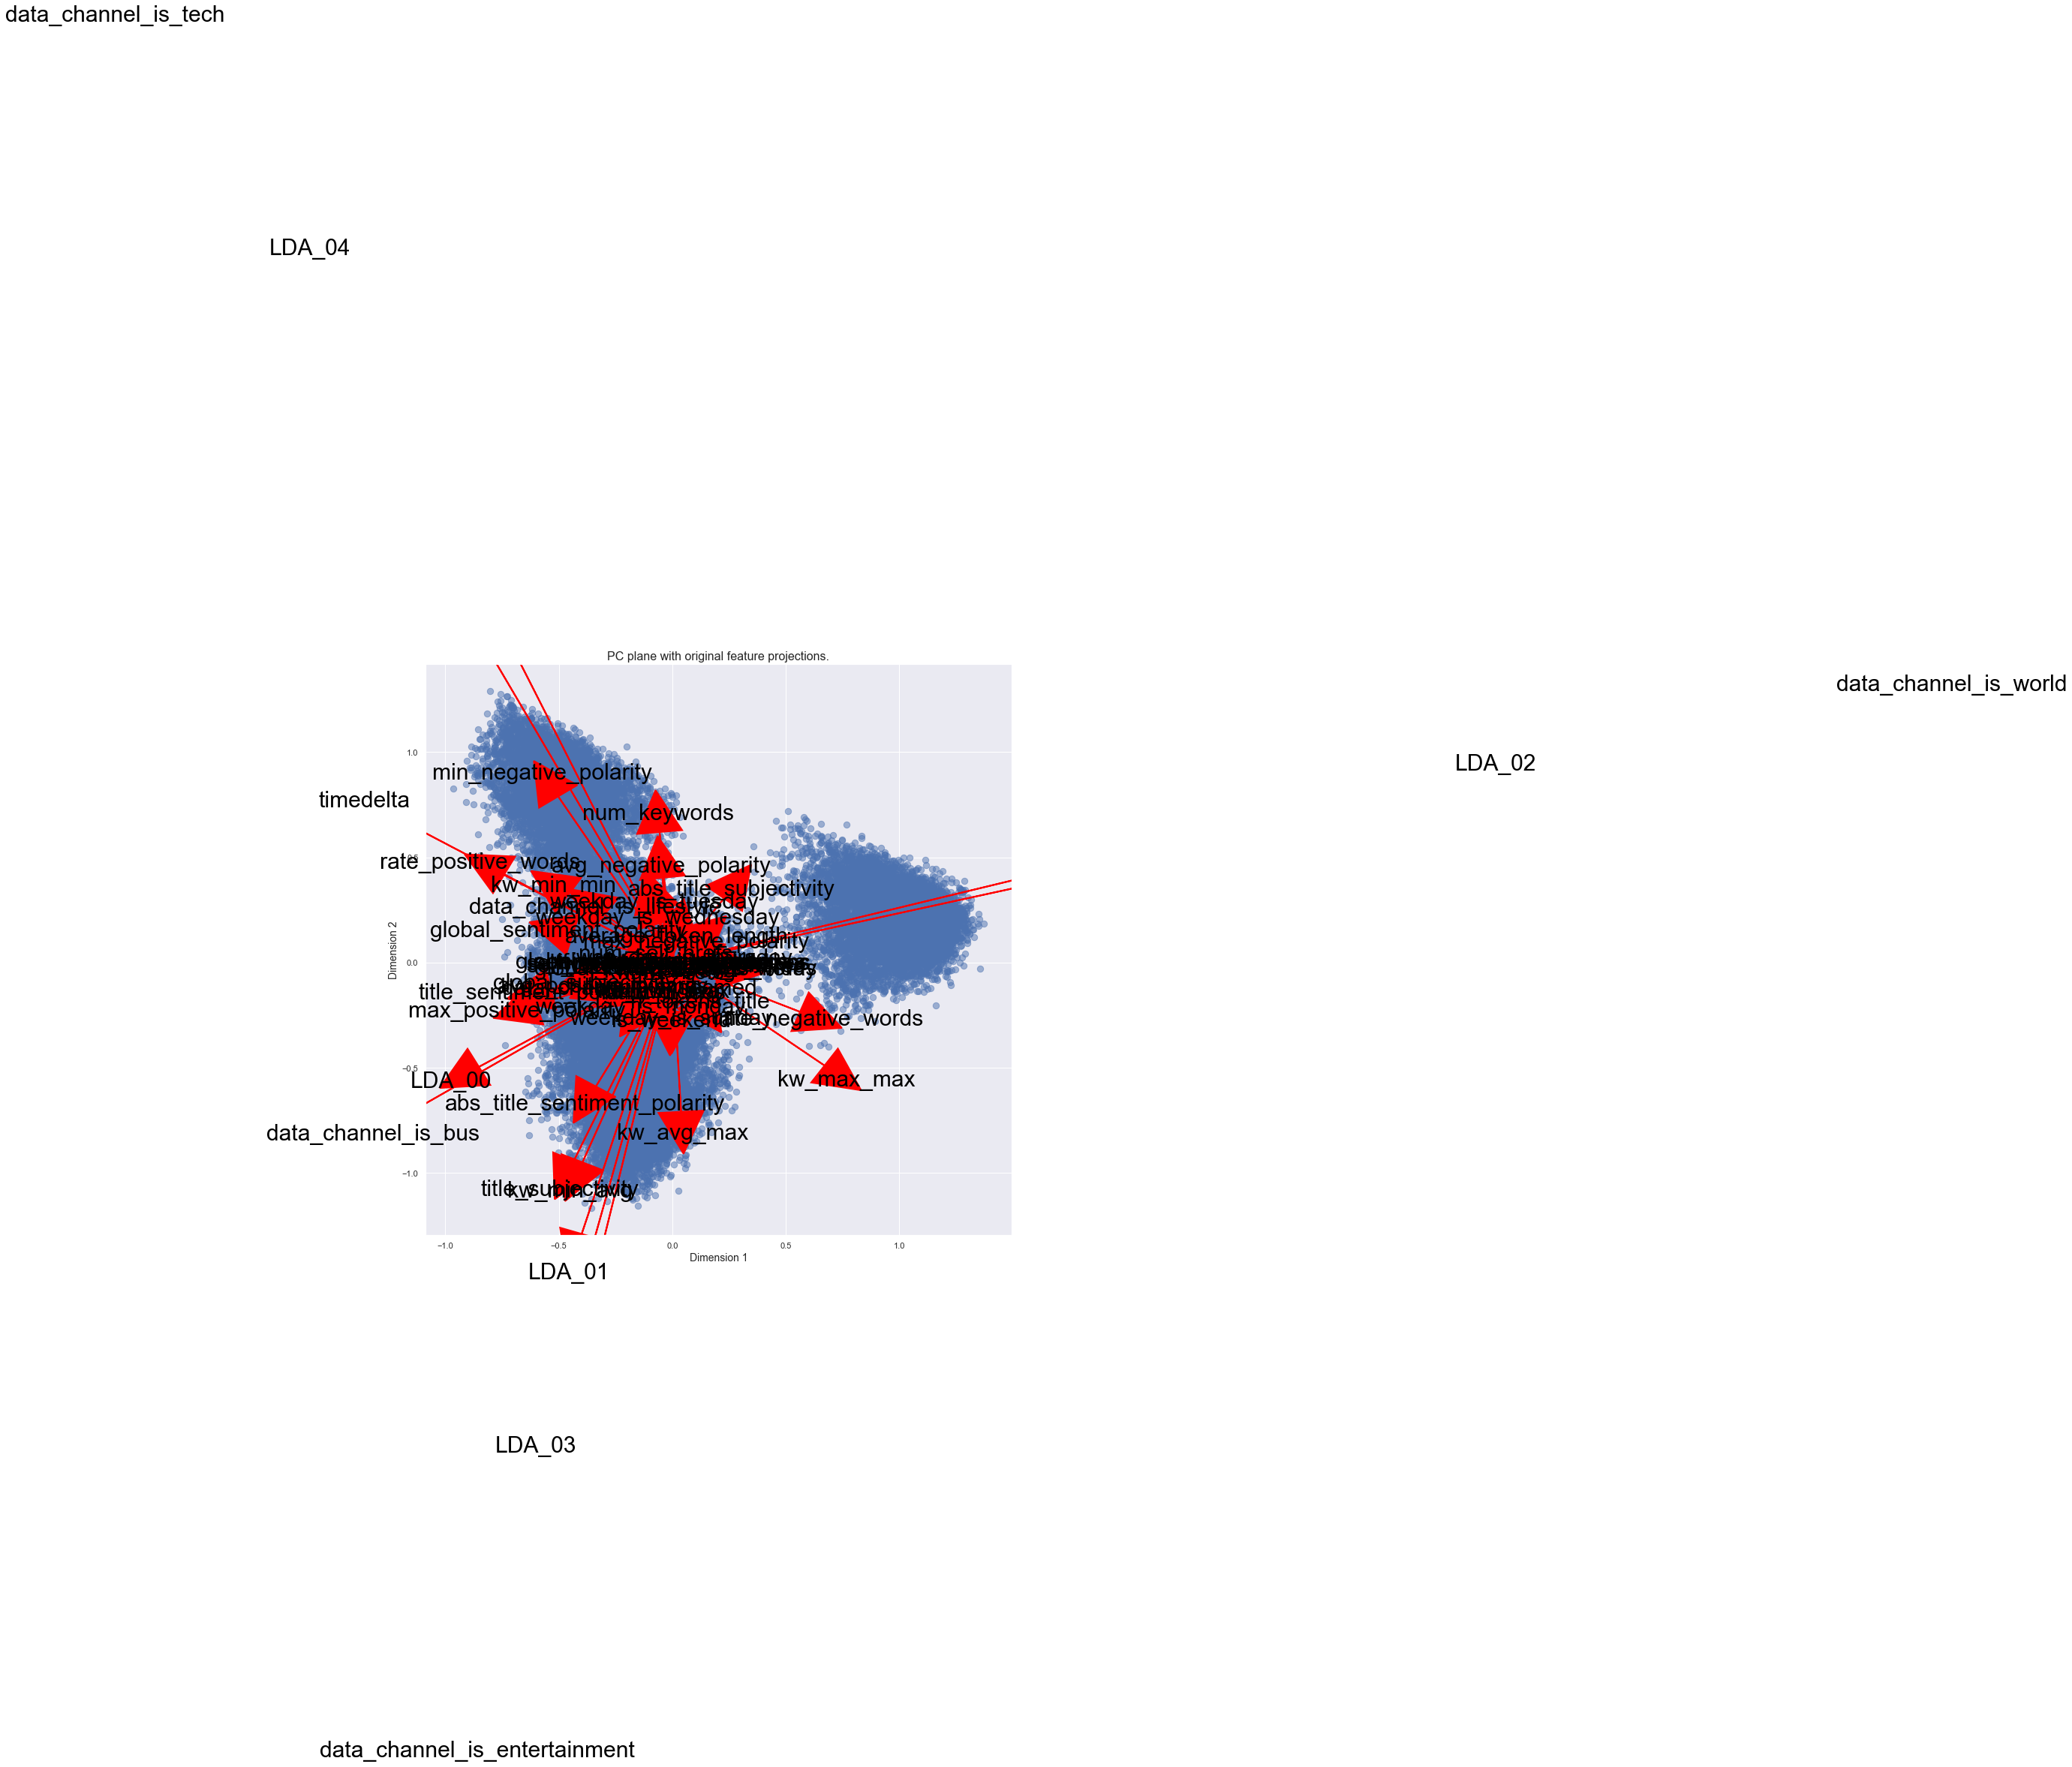

In [82]:
#biplot the original data
_ = biplot(features, reduced_df, learner)

#### Implement Gaussian mixture clustering

-----------------------------------------------------------------------
silhouette score for GMM: 0.4485
Optimal number of components: 2.0000
number of centers: 2.0000
-----------------------------------------------------------------------
-----------------------------------------------------------------------
silhouette score for GMM: 0.6703
Optimal number of components: 3.0000
number of centers: 3.0000
-----------------------------------------------------------------------
-----------------------------------------------------------------------
silhouette score for GMM: 0.5694
Optimal number of components: 4.0000
number of centers: 4.0000
-----------------------------------------------------------------------
-----------------------------------------------------------------------
silhouette score for GMM: 0.4861
Optimal number of components: 5.0000
number of centers: 5.0000
-----------------------------------------------------------------------
----------------------------------------

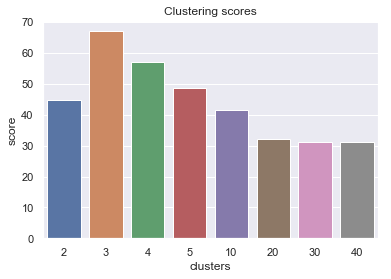

In [83]:
clus_df = pd.DataFrame(columns=['clusters','score'])
clist = [2,3,4,5,10,20,30,40]; slist = [];
for dim in clist:
    cluster, centers, score = gclus(reduced_f,dim)
    slist.append(score * 100)
    print ("-----------------------------------------------------------------------")
    print "silhouette score for GMM: {:.4f}".format(score)
    print "Optimal number of components: {:.4f}".format(cluster.n_components)
    print "number of centers: {:.4f}".format(len(centers))
    print ("-----------------------------------------------------------------------")

clus_df['clusters'] = clist
clus_df['score'] = slist

ax = sns.barplot(x="clusters", y="score", data=clus_df)
_ = ax.set_title('Clustering scores')

#### Plot the decision boundary of the cluster

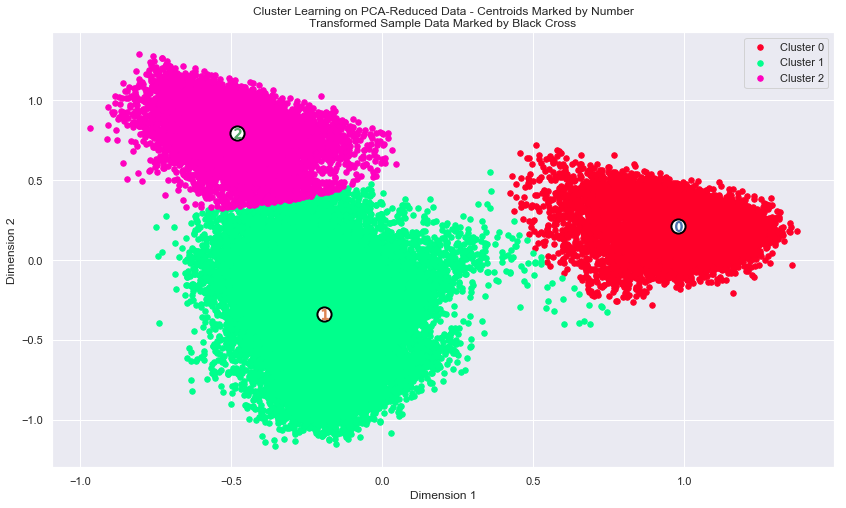

In [84]:
#Get the predictions for the best performing cluster
cluster, centers, score = gclus(reduced_f,3)

#Prediction
preds = cluster.predict(reduced_f)

#Plot the decision boundary
_=decBound(reduced_df,preds,centers)

In [71]:
data.to_csv('test.csv',index=False)